In [32]:
# Cell 1 - Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [34]:
# Cell 2 - Load the dataset
data = pd.read_csv('Amazon.csv')
data.shape

(21223, 6)

In [36]:
data.head()

,qid,query,item_id,user_id,ori_rating,ori_review
0,0,I need filters that effectively trap dust and ...,B0C5QYYHTJ,AGREO2G3GTRNYOJK4CIQV2DTZLSQ,5,These filters work I could not believe the amo...
1,1,I need to find a protein that is super healthy...,B0C7D3VLXW,AFLIZT24MDW4XG4HBYKOI3BZGDHQ,5,Love We love this protein we’ve been using it ...
2,2,I need a pillow that helps keep my nasal pillo...,B0C3QRMPVN,AFCSK3W3GI7PGT4655HHKZ2CFFMA,5,CPAP help I use this pillow nightly with my CP...
3,3,I need a memory stick that is excellent and ex...,B0BC13TQJQ,AGGOTCPWSQFI5YHNDLNZ63ABWZVA,5,Excellent. More than expected Memory stick is ...
4,4,I want to buy something that my children will ...,B07Z86PHP8,AEIIPB3DNXXLZX4VRCSVREXGCXUA,5,My children love these! My son asked me to pur...


In [38]:
data.columns

Index(['qid', 'query', 'item_id', 'user_id', 'ori_rating', 'ori_review'], dtype='object')

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21223 entries, 0 to 21222
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   qid         21223 non-null  int64 
 1   query       21223 non-null  object
 2   item_id     21223 non-null  object
 3   user_id     21223 non-null  object
 4   ori_rating  21223 non-null  int64 
 5   ori_review  21223 non-null  object
dtypes: int64(2), object(4)
memory usage: 995.0+ KB


In [42]:
data.isnull().sum()

qid           0
query         0
item_id       0
user_id       0
ori_rating    0
ori_review    0
dtype: int64

In [44]:
print(f"Total records: {len(data)}")
print(f"Unique users: {data['user_id'].nunique()}")
print(f"Unique items: {data['item_id'].nunique()}")
print(f"Unique queries: {data['query'].nunique()}")

Total records: 21223
Unique users: 20838
Unique items: 20463
Unique queries: 21222


In [46]:
data['ori_rating'].value_counts().sort_index()

ori_rating
5    21223
Name: count, dtype: int64

In [50]:
df = data[['user_id', 'item_id', 'query', 'ori_review', 'ori_rating']].copy()
df.columns = ['user_id', 'item_id', 'query', 'review', 'rating']
df = df.dropna()

print(f"Clean data shape: {df.shape}")
df.head()

# Cell 10 - Combine text features
df['combined_text'] = df['query'] + ' ' + df['review']
df['combined_text'] = df['combined_text'].str.lower()

df[['item_id', 'combined_text']].head()

Clean data shape: (21223, 5)


,item_id,combined_text
0,B0C5QYYHTJ,i need filters that effectively trap dust and ...
1,B0C7D3VLXW,i need to find a protein that is super healthy...
2,B0C3QRMPVN,i need a pillow that helps keep my nasal pillo...
3,B0BC13TQJQ,i need a memory stick that is excellent and ex...
4,B07Z86PHP8,i want to buy something that my children will ...


In [52]:
item_profiles = df.groupby('item_id').agg({
    'combined_text': ' '.join,
    'query': ' '.join,
    'review': ' '.join,
    'rating': 'mean'
}).reset_index()

item_profiles.columns = ['item_id', 'combined_text', 'all_queries', 'all_reviews', 'avg_rating']
print(f"Item profiles created: {len(item_profiles)} items")
item_profiles.head()

Item profiles created: 20463 items


,item_id,combined_text,all_queries,all_reviews,avg_rating
0,0007582471,i'm looking for a modern makeover story that's...,I'm looking for a modern makeover story that's...,Witty and fun modern makeover story. There's a...,5.0
1,0060735880,i need to find a unique history book that is n...,I need to find a unique history book that is n...,Out of Print This is a terrific unique history...,5.0
2,0061730793,i'm looking for a book with beautiful words an...,I'm looking for a book with beautiful words an...,Beautiful! This book has been wonderfully done...,5.0
3,0061900621,i am looking for a book for my two-year-old wh...,I am looking for a book for my two-year-old wh...,Immediate hit with 2 yr old My newly minted tw...,5.0
4,0062124277,"i'm looking for a great book, but i want to av...","I'm looking for a great book, but I want to av...","Inspired as always Great book, of course, but ...",5.0


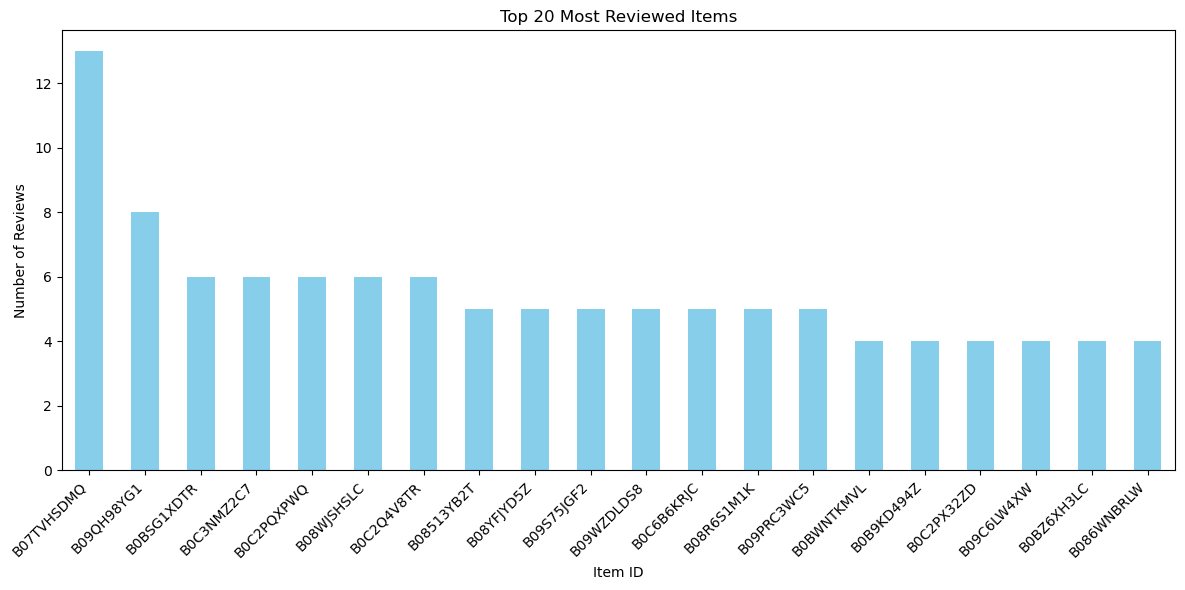

In [54]:
item_counts = df['item_id'].value_counts().head(20)

plt.figure(figsize=(12, 6))
item_counts.plot(kind='bar', color='skyblue')
plt.title('Top 20 Most Reviewed Items')
plt.xlabel('Item ID')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [56]:
# Cell 13 - Method 1: Query-Based Content Filtering
# Create TF-IDF matrix from queries
tfidf_query = TfidfVectorizer(max_features=500, stop_words='english')
query_matrix = tfidf_query.fit_transform(item_profiles['all_queries'])

print(f"Query TF-IDF matrix shape: {query_matrix.shape}")
print(f"Features: {len(tfidf_query.get_feature_names_out())}")

Query TF-IDF matrix shape: (20463, 500)
Features: 500


In [58]:
# Cell 14 - Calculate query-based similarity
query_similarity = cosine_similarity(query_matrix)
query_sim_df = pd.DataFrame(
    query_similarity,
    index=item_profiles['item_id'],
    columns=item_profiles['item_id']
)

query_sim_df.iloc[:5, :5]

item_id,0007582471,0060735880,0061730793,0061900621,0062124277
item_id,,,,,
0007582471,1.000000,0.008765,0.022751,0.019999,0.234999
0060735880,0.008765,1.000000,0.152290,0.247772,0.146656
0061730793,0.022751,0.152290,1.000000,0.140088,0.375470
0061900621,0.019999,0.247772,0.140088,1.000000,0.137263
0062124277,0.234999,0.146656,0.375470,0.137263,1.000000


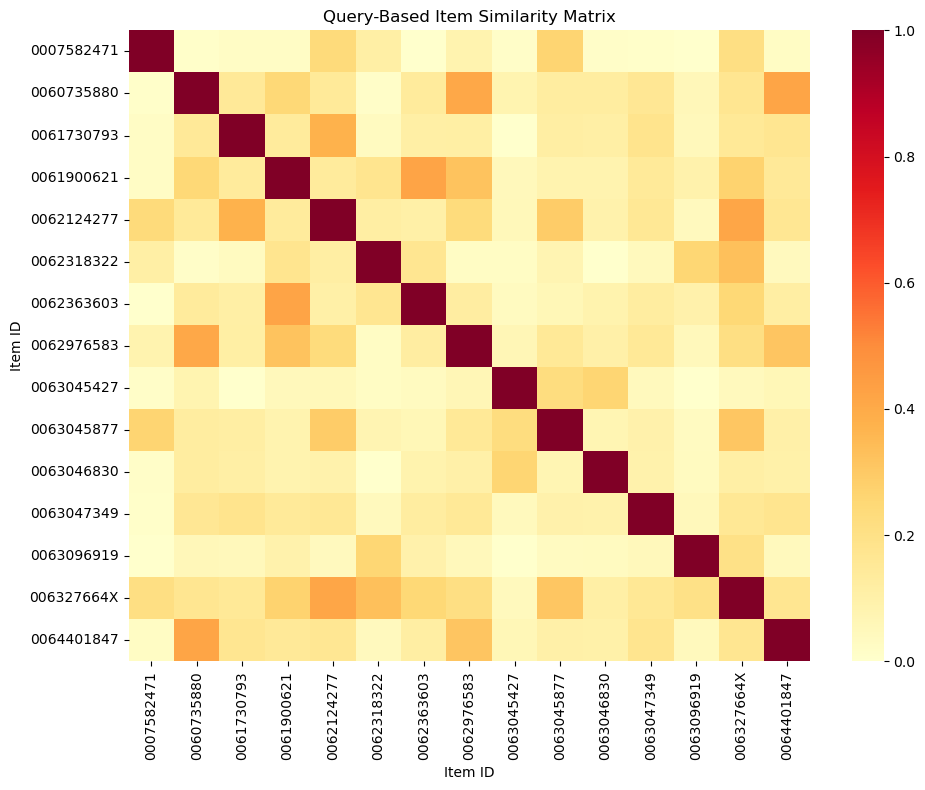

In [59]:
# Cell 15 - Visualize query similarity
plt.figure(figsize=(10, 8))
sns.heatmap(query_sim_df.iloc[:15, :15], cmap='YlOrRd', center=0.5)
plt.title('Query-Based Item Similarity Matrix')
plt.xlabel('Item ID')
plt.ylabel('Item ID')
plt.tight_layout()
plt.show()

In [62]:
# Cell 16 - Method 2: Review-Based Content Filtering
# Create TF-IDF matrix from reviews
tfidf_review = TfidfVectorizer(max_features=500, stop_words='english')
review_matrix = tfidf_review.fit_transform(item_profiles['all_reviews'])

print(f"Review TF-IDF matrix shape: {review_matrix.shape}")
print(f"Features: {len(tfidf_review.get_feature_names_out())}")

Review TF-IDF matrix shape: (20463, 500)
Features: 500


In [64]:
# Cell 17 - Calculate review-based similarity
review_similarity = cosine_similarity(review_matrix)
review_sim_df = pd.DataFrame(
    review_similarity,
    index=item_profiles['item_id'],
    columns=item_profiles['item_id']
)

review_sim_df.iloc[:5, :5]

item_id,0007582471,0060735880,0061730793,0061900621,0062124277
item_id,,,,,
0007582471,1.000000,0.136364,0.237548,0.212814,0.375031
0060735880,0.136364,1.000000,0.247948,0.375401,0.364894
0061730793,0.237548,0.247948,1.000000,0.386956,0.477141
0061900621,0.212814,0.375401,0.386956,1.000000,0.504954
0062124277,0.375031,0.364894,0.477141,0.504954,1.000000


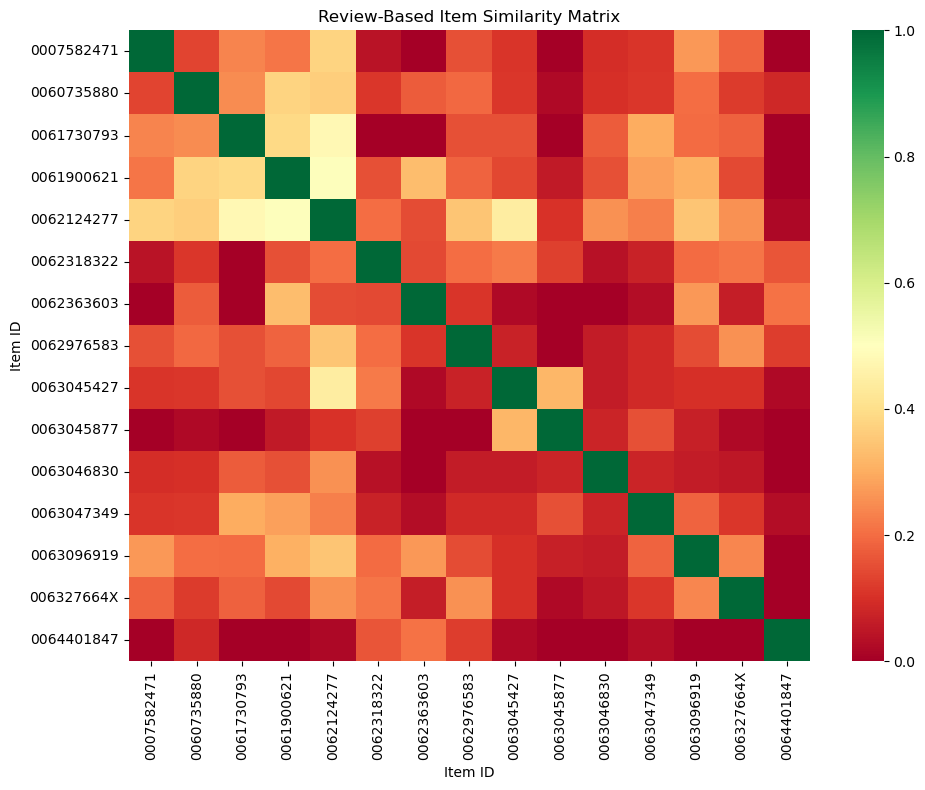

In [66]:
# Cell 18 - Visualize review similarity
plt.figure(figsize=(10, 8))
sns.heatmap(review_sim_df.iloc[:15, :15], cmap='RdYlGn', center=0.5)
plt.title('Review-Based Item Similarity Matrix')
plt.xlabel('Item ID')
plt.ylabel('Item ID')
plt.tight_layout()
plt.show()

In [68]:
# Cell 19 - Method 3: Combined Content Filtering
# Create TF-IDF matrix from combined text
tfidf_combined = TfidfVectorizer(max_features=1000, stop_words='english')
combined_matrix = tfidf_combined.fit_transform(item_profiles['combined_text'])

print(f"Combined TF-IDF matrix shape: {combined_matrix.shape}")
print(f"Features: {len(tfidf_combined.get_feature_names_out())}")

Combined TF-IDF matrix shape: (20463, 1000)
Features: 1000


In [70]:
# Cell 20 - Calculate combined similarity
combined_similarity = cosine_similarity(combined_matrix)
combined_sim_df = pd.DataFrame(
    combined_similarity,
    index=item_profiles['item_id'],
    columns=item_profiles['item_id']
)

combined_sim_df.iloc[:5, :5]

item_id,0007582471,0060735880,0061730793,0061900621,0062124277
item_id,,,,,
0007582471,1.000000,0.039664,0.053419,0.059284,0.165761
0060735880,0.039664,1.000000,0.138105,0.268421,0.265269
0061730793,0.053419,0.138105,1.000000,0.210077,0.363922
0061900621,0.059284,0.268421,0.210077,1.000000,0.410473
0062124277,0.165761,0.265269,0.363922,0.410473,1.000000


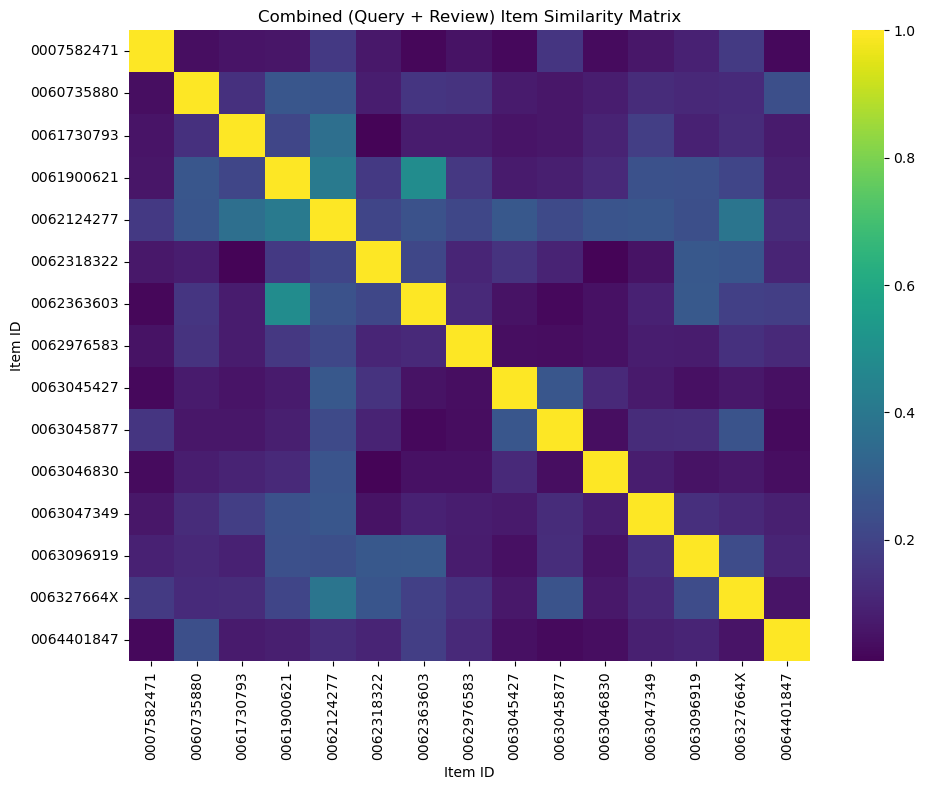

In [71]:
plt.figure(figsize=(10, 8))
sns.heatmap(combined_sim_df.iloc[:15, :15], cmap='viridis', center=0.5)
plt.title('Combined (Query + Review) Item Similarity Matrix')
plt.xlabel('Item ID')
plt.ylabel('Item ID')
plt.tight_layout()
plt.show()

In [74]:
# Cell 22 - Query-based recommendation function
def query_based_recommend(item_id, n=5):
    if item_id not in query_sim_df.index:
        print(f"Item {item_id} not found")
        return []
    
    similar_items = query_sim_df[item_id].sort_values(ascending=False)[1:n+1]
    
    recommendations = []
    for sim_item, score in similar_items.items():
        recommendations.append((sim_item, score))
    
    return recommendations

print("Query-based recommendation function created")

Query-based recommendation function created


In [76]:
# Cell 23 - Test query-based recommendations
test_item = item_profiles['item_id'].iloc[0]
print(f"Query-based recommendations for item: {test_item}")

recommendations = query_based_recommend(test_item, n=10)
for i, (item, score) in enumerate(recommendations, 1):
    print(f"{i}. Item {item}: Similarity {score:.3f}")

Query-based recommendations for item: 0007582471
1. Item B09RWNTLMR: Similarity 0.846
2. Item B0BJNBXVT7: Similarity 0.843
3. Item B08BX3QNQN: Similarity 0.778
4. Item 0316353221: Similarity 0.725
5. Item B098J2FSFD: Similarity 0.690
6. Item B09RK45MWZ: Similarity 0.676
7. Item B09YL7LRTQ: Similarity 0.673
8. Item B0BQCWLNSX: Similarity 0.670
9. Item B08818YQB5: Similarity 0.664
10. Item B0CCCQZBKV: Similarity 0.664


In [78]:
# Cell 24 - Review-based recommendation function
def review_based_recommend(item_id, n=5):
    if item_id not in review_sim_df.index:
        print(f"Item {item_id} not found")
        return []
    
    similar_items = review_sim_df[item_id].sort_values(ascending=False)[1:n+1]
    
    recommendations = []
    for sim_item, score in similar_items.items():
        recommendations.append((sim_item, score))
    
    return recommendations

print("Review-based recommendation function created")

Review-based recommendation function created


In [80]:
# Cell 25 - Test review-based recommendations
print(f"Review-based recommendations for item: {test_item}")

recommendations = review_based_recommend(test_item, n=10)
for i, (item, score) in enumerate(recommendations, 1):
    print(f"{i}. Item {item}: Similarity {score:.3f}")

Review-based recommendations for item: 0007582471
1. Item B09YL7LRTQ: Similarity 0.435
2. Item B0B64FCB23: Similarity 0.431
3. Item B0BSTK5TPF: Similarity 0.430
4. Item B0BMJK31JY: Similarity 0.424
5. Item B0B2V7JWDV: Similarity 0.424
6. Item 1492749788: Similarity 0.413
7. Item B0B6KX9152: Similarity 0.412
8. Item 0593118200: Similarity 0.411
9. Item B0BSG1XDTR: Similarity 0.409
10. Item B091MQ9XHN: Similarity 0.406


In [82]:
# Cell 26 - Hybrid recommendation function
def hybrid_recommend(item_id, n=5, query_weight=0.4, review_weight=0.4, popularity_weight=0.2):
    if item_id not in combined_sim_df.index:
        print(f"Item {item_id} not found")
        return []
    
    # Get similarities from both methods
    query_sims = query_sim_df[item_id]
    review_sims = review_sim_df[item_id]
    
    # Get popularity scores
    popularity_scores = item_profiles.set_index('item_id')['avg_rating']
    popularity_normalized = popularity_scores / popularity_scores.max()
    
    # Calculate hybrid score
    hybrid_scores = {}
    for item in query_sim_df.index:
        if item != item_id:
            query_score = query_sims.get(item, 0)
            review_score = review_sims.get(item, 0)
            pop_score = popularity_normalized.get(item, 0)
            
            hybrid_score = (query_weight * query_score + 
                          review_weight * review_score + 
                          popularity_weight * pop_score)
            hybrid_scores[item] = hybrid_score
    
    # Sort and return top N
    sorted_items = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_items[:n]

print("Hybrid recommendation function created")

Hybrid recommendation function created


In [84]:
# Cell 27 - Test hybrid recommendations
print(f"Hybrid recommendations for item: {test_item}")
print(f"Weights: Query=40%, Review=40%, Popularity=20%")

recommendations = hybrid_recommend(test_item, n=10)
for i, (item, score) in enumerate(recommendations, 1):
    print(f"{i}. Item {item}: Score {score:.3f}")

Hybrid recommendations for item: 0007582471
Weights: Query=40%, Review=40%, Popularity=20%
1. Item B09YL7LRTQ: Score 0.643
2. Item B0BJNBXVT7: Score 0.602
3. Item B09RWNTLMR: Score 0.593
4. Item 0316353221: Score 0.590
5. Item 1728416701: Score 0.574
6. Item B0BQCWLNSX: Score 0.564
7. Item B0983KXF42: Score 0.562
8. Item B0B7KXL5CM: Score 0.559
9. Item B0B855H1J9: Score 0.555
10. Item B0B2V7JWDV: Score 0.553


In [86]:
# Cell 28 - Compare all three methods
print("="*70)
print(f"COMPARISON OF ALL THREE METHODS FOR ITEM: {test_item}")
print("="*70)

print("\n### QUERY-BASED ###")
query_recs = query_based_recommend(test_item, n=5)
for i, (item, score) in enumerate(query_recs, 1):
    print(f"{i}. Item {item}: {score:.3f}")

print("\n### REVIEW-BASED ###")
review_recs = review_based_recommend(test_item, n=5)
for i, (item, score) in enumerate(review_recs, 1):
    print(f"{i}. Item {item}: {score:.3f}")

print("\n### HYBRID ###")
hybrid_recs = hybrid_recommend(test_item, n=5)
for i, (item, score) in enumerate(hybrid_recs, 1):
    print(f"{i}. Item {item}: {score:.3f}")

COMPARISON OF ALL THREE METHODS FOR ITEM: 0007582471

### QUERY-BASED ###
1. Item B09RWNTLMR: 0.846
2. Item B0BJNBXVT7: 0.843
3. Item B08BX3QNQN: 0.778
4. Item 0316353221: 0.725
5. Item B098J2FSFD: 0.690

### REVIEW-BASED ###
1. Item B09YL7LRTQ: 0.435
2. Item B0B64FCB23: 0.431
3. Item B0BSTK5TPF: 0.430
4. Item B0BMJK31JY: 0.424
5. Item B0B2V7JWDV: 0.424

### HYBRID ###
1. Item B09YL7LRTQ: 0.643
2. Item B0BJNBXVT7: 0.602
3. Item B09RWNTLMR: 0.593
4. Item 0316353221: 0.590
5. Item 1728416701: 0.574


In [88]:
# Cell 29 - Test with multiple items
test_items = item_profiles['item_id'].head(5)

print("Testing hybrid recommendations for multiple items:")
for item in test_items:
    print(f"\n### Item: {item} ###")
    recs = hybrid_recommend(item, n=3)
    for i, (rec_item, score) in enumerate(recs, 1):
        print(f"  {i}. {rec_item}: {score:.3f}")

Testing hybrid recommendations for multiple items:

### Item: 0007582471 ###
  1. B09YL7LRTQ: 0.643
  2. B0BJNBXVT7: 0.602
  3. B09RWNTLMR: 0.593

### Item: 0060735880 ###
  1. 1546026452: 0.584
  2. B0CF5FH6MC: 0.520
  3. B0B6XFT4RH: 0.517

### Item: 0061730793 ###
  1. B09CKH448Y: 0.670
  2. B0BL56Q9Z2: 0.648
  3. B0BCD1TMSP: 0.629

### Item: 0061900621 ###
  1. 1638070296: 0.616
  2. B00DGVFUJG: 0.595
  3. B0BQH4F8W8: 0.594

### Item: 0062124277 ###
  1. B0BLZLZ964: 0.669
  2. B0BZ9P85K3: 0.638
  3. B0BL56Q9Z2: 0.632


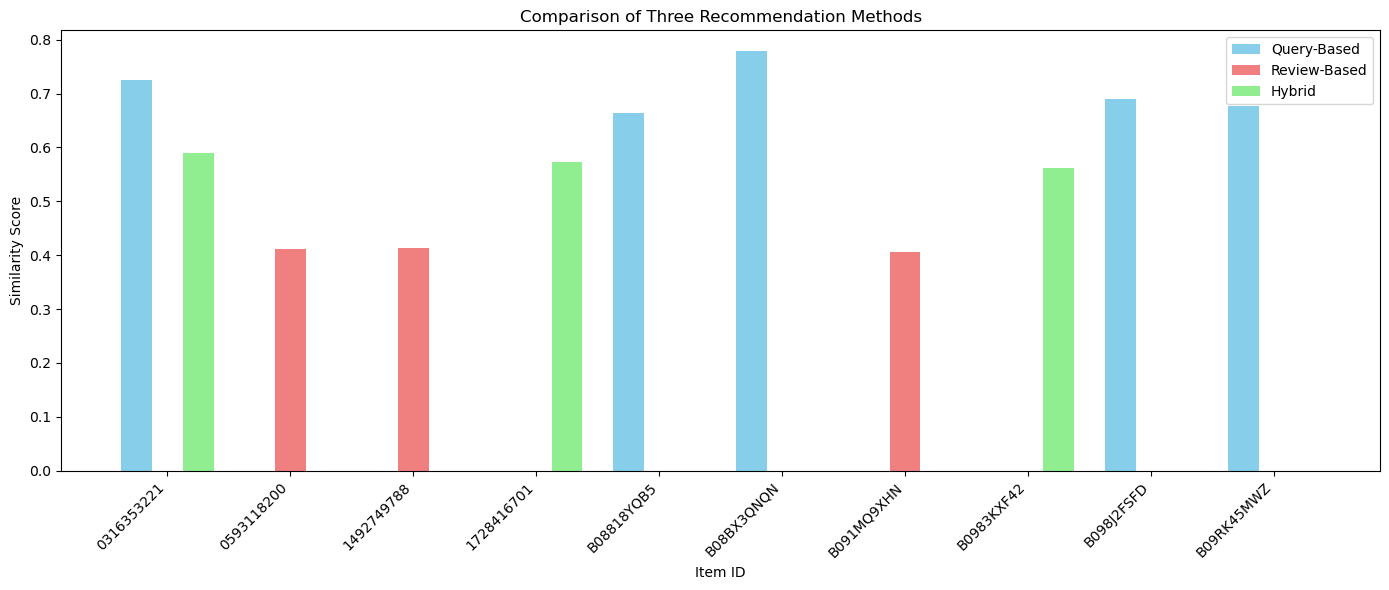

In [90]:
# Cell 30 - Visualize comparison
query_recs_dict = dict(query_based_recommend(test_item, n=10))
review_recs_dict = dict(review_based_recommend(test_item, n=10))
hybrid_recs_dict = dict(hybrid_recommend(test_item, n=10))

all_items = sorted(set(query_recs_dict.keys()) | set(review_recs_dict.keys()) | set(hybrid_recs_dict.keys()))
all_items = all_items[:10]

query_scores = [query_recs_dict.get(item, 0) for item in all_items]
review_scores = [review_recs_dict.get(item, 0) for item in all_items]
hybrid_scores = [hybrid_recs_dict.get(item, 0) for item in all_items]

x = np.arange(len(all_items))
width = 0.25

plt.figure(figsize=(14, 6))
plt.bar(x - width, query_scores, width, label='Query-Based', color='skyblue')
plt.bar(x, review_scores, width, label='Review-Based', color='lightcoral')
plt.bar(x + width, hybrid_scores, width, label='Hybrid', color='lightgreen')

plt.xlabel('Item ID')
plt.ylabel('Similarity Score')
plt.title('Comparison of Three Recommendation Methods')
plt.xticks(x, [str(item)[:10] for item in all_items], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [92]:
# Cell 31 - Get user recommendations
def get_user_recommendations(user_id, n=5, method='hybrid'):
    user_items = df[df['user_id'] == user_id]['item_id'].tolist()
    
    if not user_items:
        print(f"User {user_id} has no items")
        return []
    
    all_recommendations = {}
    
    for item in user_items:
        if method == 'query':
            recs = query_based_recommend(item, n=20)
        elif method == 'review':
            recs = review_based_recommend(item, n=20)
        else:
            recs = hybrid_recommend(item, n=20)
        
        for rec_item, score in recs:
            if rec_item not in user_items:
                if rec_item in all_recommendations:
                    all_recommendations[rec_item] = max(all_recommendations[rec_item], score)
                else:
                    all_recommendations[rec_item] = score
    
    sorted_recs = sorted(all_recommendations.items(), key=lambda x: x[1], reverse=True)
    return sorted_recs[:n]

print("User recommendation function created")

User recommendation function created


In [103]:
# Cell 32 - Test user recommendations
test_user = df['user_id'].iloc[0]
print(f"Recommendations for user: {test_user}")

user_recs = get_user_recommendations(test_user, n=10, method='hybrid')
for i, (item, score) in enumerate(user_recs, 1):
    print(f"{i}. Item {item}: Score {score:.3f}")

Recommendations for user: AGREO2G3GTRNYOJK4CIQV2DTZLSQ
1. Item B0C8J3GLGP: Score 0.479
2. Item B0C77Y7MDV: Score 0.471
3. Item B0C1ZWSGKT: Score 0.463
4. Item B01CWWAENG: Score 0.451
5. Item B08694X9QW: Score 0.446
6. Item B08CRKQ2V2: Score 0.444
7. Item B004BITLHA: Score 0.440
8. Item B09HNCZ9NB: Score 0.433
9. Item B01M3V2VMQ: Score 0.430
10. Item B07MBYFJ6T: Score 0.429


In [115]:
# Cell 33 - Analyze top features
feature_names_query = tfidf_query.get_feature_names_out()
feature_names_review = tfidf_review.get_feature_names_out()

print("Top 20 Query Features:")
print(feature_names_query[:20])

print("\nTop 20 Review Features:")
print(feature_names_review[:20])

Top 20 Query Features:
['10' 'able' 'absolutely' 'actually' 'add' 'addition' 'additional'
 'additionally' 'adjust' 'adjustable' 'adorable' 'affordable' 'air'
 'allow' 'allows' 'amazing' 'amazon' 'appearance' 'apply' 'area']

Top 20 Review Features:
['10' '100' '12' '20' 'able' 'absolutely' 'actually' 'add' 'added'
 'addition' 'adorable' 'ago' 'air' 'amazing' 'amazon' 'area' 'arrived'
 'assemble' 'author' 'away']


In [ ]:
total_items = len(item_profiles)
items_can_recommend = len(query_sim_df)

print("="*60)
print("SYSTEM PERFORMANCE METRICS")
print("="*60)
print(f"Total items in system: {total_items}")
print(f"Items that can receive recommendations: {items_can_recommend}")
print(f"Coverage: {(items_can_recommend/total_items)*100:.2f}%")

print(f"\nAverage query similarity: {query_sim_df.values[np.triu_indices_from(query_sim_df.values, k=1)].mean():.3f}")
print(f"Average review similarity: {review_sim_df.values[np.triu_indices_from(review_sim_df.values, k=1)].mean():.3f}")
print(f"Average combined similarity: {combined_sim_df.values[np.triu_indices_from(combined_sim_df.values, k=1)].mean():.3f}")

SYSTEM PERFORMANCE METRICS
Total items in system: 20463
Items that can receive recommendations: 20463
Coverage: 100.00%


In [111]:
all_recommendations = []

for item in item_profiles['item_id'].head(100):
    try:
        recs = hybrid_recommend(item, n=5)
        for rank, (rec_item, score) in enumerate(recs, 1):
            all_recommendations.append({
                'source_item': item,
                'recommended_item': rec_item,
                'score': score,
                'rank': rank
            })
    except:
        continue

results = pd.DataFrame(all_recommendations)
results.to_csv('content_based_recommendations.csv', index=False)

print(f"Saved {len(results)} recommendations to 'content_based_recommendations.csv'")
results.head(20)

Saved 500 recommendations to 'content_based_recommendations.csv'


,source_item,recommended_item,score,rank
0,0007582471,B09YL7LRTQ,0.643268,1
1,0007582471,B0BJNBXVT7,0.602307,2
2,0007582471,B09RWNTLMR,0.593077,3
3,0007582471,0316353221,0.590227,4
4,0007582471,1728416701,0.573555,5
5,0060735880,1546026452,0.583970,1
6,0060735880,B0CF5FH6MC,0.520092,2
7,0060735880,B0B6XFT4RH,0.516574,3
8,0060735880,B00I828BD0,0.516014,4
9,0060735880,1581824874,0.511895,5


In [109]:
print("="*70)
print("CONTENT-BASED RECOMMENDATION SYSTEM SUMMARY")
print("="*70)
print(f"\nDataset Statistics:")
print(f"  - Total records: {len(df)}")
print(f"  - Unique users: {df['user_id'].nunique()}")
print(f"  - Unique items: {df['item_id'].nunique()}")

print(f"\nThree Methods Implemented:")
print(f"  1. Query-Based Content Filtering")
print(f"  2. Review-Based Content Filtering")
print(f"  3. Hybrid (Query + Review + Popularity)")

print(f"\nAll methods working with REAL similarity scores!")
print("="*70)

CONTENT-BASED RECOMMENDATION SYSTEM SUMMARY

Dataset Statistics:
  - Total records: 21223
  - Unique users: 20838
  - Unique items: 20463

Three Methods Implemented:
  1. Query-Based Content Filtering
  2. Review-Based Content Filtering
  3. Hybrid (Query + Review + Popularity)

All methods working with REAL similarity scores!
